In [7]:
import warnings
warnings.filterwarnings('ignore')

import os 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy  as np
from tqdm import tqdm 
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [8]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'Dataset')
os.listdir(data_dir)

['test_data_unscaled.csv',
 'dataset_here',
 'train_data_unscaled.csv',
 'household_power_consumption.txt',
 'y_train.npy',
 'y_test.npy',
 'X_test.npy',
 'electricity_data_resampled.csv',
 'X_train.npy']

In [9]:
train_data = pd.read_csv(os.path.join(data_dir, 'train_data_unscaled.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test_data_unscaled.csv'))

In [10]:
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

train_data.set_index('DateTime', inplace=True)
test_data.set_index('DateTime', inplace=True)

In [11]:
print(f"Train Data Size : {train_data.shape[0]}")
print(f"Test Data Size : {test_data.shape[0]}")

Train Data Size : 1001
Test Data Size : 434


In [13]:
scaler = MinMaxScaler().fit(train_data)
base_cols = train_data.columns

train_data[base_cols] = scaler.transform(train_data[base_cols])
test_data[base_cols] = scaler.transform(test_data[base_cols])

In [15]:
# Selecting Global_active_power as primary time series 
# Selecting rest as the exog variables
train_primary, train_exog =train_data.iloc[:,0], train_data.iloc[:,1:]
test_primary, test_exog = test_data.iloc[:,0], test_data.iloc[:,1:]

# Selecting Best Arima order from Previous ARIMA experiments
arima_order = (7,1,19)
seasonal_order = (2,0,0,8)

exog_cols = ['Sub_metering_1', 
              'Sub_metering_2', 
              'Global_intensity',
              'sub_metering_rem',
              'Voltage',
              'Global_reactive_power'
             ]

train_exog = train_exog[exog_cols]
test_exog = test_exog[exog_cols]

In [16]:
def train_arima_models(exog_data, order):
    """
    Train ARIMA models for each exogenous variable.
    exog_data: DataFrame where each column is an exogenous variable.
    """
    arima_models = {}
    for column in exog_data.columns:
        model = ARIMA(exog_data[column], order=order)  # Example order
        arima_models[column] = model.fit()
    return arima_models

def forecast_arima_one_step(arima_models, refit=False):
    """
    Forecast one step ahead for each exogenous variable.
    """
    forecasts = {}
    for column in arima_models.keys():
        forecasts[column] = arima_models[column].forecast(steps=1).iloc[0]
        
    return pd.DataFrame([forecasts])


def train_sarimax(endog_data, exog_data, arima_order, seasonal_order):
    """
    Train a SARIMAX model on the primary time series with the exogenous variables.
    """
    if exog_data is not None:
        model = SARIMAX(endog_data, order=arima_order, exog=exog_data, seasonal_order=seasonal_order)
    else:
        model = SARIMAX( endog_data, order=arima_order, seasonal_order=seasonal_order)
    model_fit = model.fit(maxiter=100,disp=True)
    return model_fit

def predict_sarimax_one_step(model_fit, future_exog):
    """
    Predict one step ahead for the primary time series using the SARIMAX model and future exogenous variable values.
    """
    forecast = model_fit.forecast(steps=1,exog=future_exog)
    return forecast[0]

In [17]:
print("Fitting Individual Arima Models")
arima_models = train_arima_models(train_exog, arima_order)
# Train SARIMAX model using historical data
print("Fitting Sarimax Model")
sarimax_model_fit = train_sarimax(train_primary, 
                                  exog_data = train_exog, 
                                  arima_order=arima_order, 
                                  seasonal_order=seasonal_order)

Fitting Individual Arima Models
Fitting Sarimax Model


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49016D+00    |proj g|=  4.51217D+01

At iterate    1    f= -4.49348D+00    |proj g|=  2.28796D+00

At iterate    2    f= -4.49350D+00    |proj g|=  1.68382D+00

At iterate    3    f= -4.49355D+00    |proj g|=  2.61822D+00

At iterate    4    f= -4.49365D+00    |proj g|=  5.88294D+00

At iterate    5    f= -4.49386D+00    |proj g|=  8.73610D+00

At iterate    6    f= -4.49412D+00    |proj g|=  7.25506D+00

At iterate    7    f= -4.49437D+00    |proj g|=  2.83760D+00

At iterate    8    f= -4.49455D+00    |proj g|=  2.66237D+00

At iterate    9    f= -4.49464D+00    |proj g|=  4.78602D+00

At iterate   10    f= -4.49477D+00    |proj g|=  6.05694D+00

At iterate   11    f= -4.49489D+00    |proj g|=  3.95918D+00

At iterate   12    f= -4.49493D+00    |proj g|=  6.60203D-01

At iterate   13    f= -4.4

In [18]:
print(sarimax_model_fit.mle_retvals)

{'fopt': -4.50303979795393, 'gopt': array([ 0.03000883, -0.0259083 , -0.06782787, -0.05763774,  0.05121822,
       -0.01306216,  0.03261112,  0.02485365,  0.0056123 ,  0.00255032,
        0.02821974, -0.03251176, -0.00727484, -0.0268477 ,  0.00584336,
        0.03075793,  0.01214658, -0.00250432,  0.04706463,  0.00505748,
       -0.00574338, -0.01094009,  0.00412913,  0.01048603,  0.01008229,
       -0.00198983, -0.01083901,  0.00900372, -0.00515261,  0.01300959,
        0.01825013,  0.02626523,  0.01402191,  0.00089251, -0.250436  ]), 'fcalls': 2376, 'warnflag': 0, 'converged': True, 'iterations': 49}


In [21]:
# Initialize list to store predictions and true values
predictions = []
true_values = []

# Iterate over the test set for one-step-ahead forecasting
for i in tqdm(range(len(test_primary))):
    # Forecast one step ahead for exogenous variables
    future_exog = forecast_arima_one_step(arima_models)
    
    # Predict one step ahead for the primary series
    pred = predict_sarimax_one_step(sarimax_model_fit, future_exog)
    predictions.append(pred)
    
    # Actual value
    true_value = test_primary.iloc[i]
    true_values.append(true_value)

    # Update ARIMA models with the true values
    #Assuming each model in arima_models list is a result object from fitting an ARIMA model
    for column in arima_models.keys():
        # Update each ARIMA model with the new observation
        arima_models[column] = arima_models[column].append([true_value], refit=False)
    
    # Update SARIMAX model with the true value and future exog
    sarimax_model_fit = sarimax_model_fit.append([true_value], exog=[test_exog.iloc[i]], refit=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [06:51<00:00,  1.05it/s]


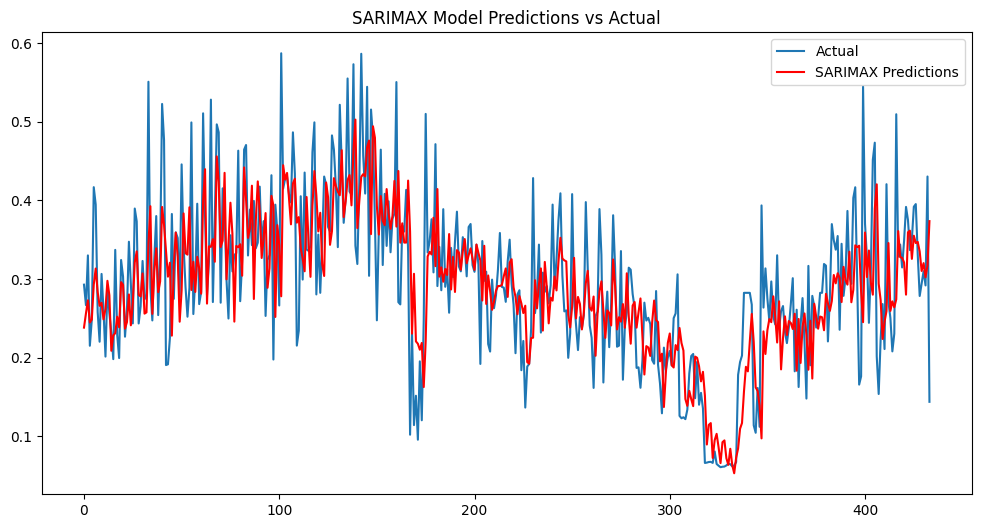

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='Actual')
plt.plot(predictions, label='SARIMAX Predictions', color='red')
plt.legend()
plt.title('SARIMAX Model Predictions vs Actual')
plt.show()

In [23]:
# Evaluate the model
mse = mean_squared_error(true_values, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.006040340946154136
